# ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# データの読み込み

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
test_df = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
test_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


# 簡単なデータの確認

In [4]:
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    print(f'(index, col) : {df.shape}')
    return info_df

information_df(train_df)

(index, col) : (165034, 14)


,dtypes,NaN Count,Nunique,Unique Values
id,int64,0,165034,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
CustomerId,int64,0,23221,"[15674932, 15749177, 15694510, 15741417, 15766..."
Surname,object,0,2797,"[Okwudilichukwu, Okwudiliolisa, Hsueh, Kao, Ch..."
CreditScore,int64,0,457,"[668, 627, 678, 581, 716, 588, 593, 676, 583, ..."
Geography,object,0,3,"[France, Spain, Germany]"
Gender,object,0,2,"[Male, Female]"
Age,float64,0,71,"[33.0, 40.0, 34.0, 36.0, 30.0, 37.0, 43.0, 27...."
Tenure,int64,0,11,"[3, 1, 10, 2, 5, 4, 8, 6, 9, 7, 0]"
Balance,float64,0,30075,"[0.0, 148882.54, 131778.58, 144772.69, 138476...."
NumOfProducts,int64,0,4,"[2, 1, 3, 4]"


In [5]:
# (0：解約していない、1：解約)
train_df['Exited'].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

In [6]:
information_df(test_df)

(index, col) : (110023, 13)


,dtypes,NaN Count,Nunique,Unique Values
id,int64,0,110023,"[165034, 165035, 165036, 165037, 165038, 16503..."
CustomerId,int64,0,19698,"[15773898, 15782418, 15807120, 15808905, 15607..."
Surname,object,0,2708,"[Lucchese, Nott, K?, O'Donnell, Higgins, Pears..."
CreditScore,int64,0,454,"[586, 683, 656, 681, 752, 593, 682, 539, 845, ..."
Geography,object,0,3,"[France, Germany, Spain]"
Gender,object,0,2,"[Female, Male]"
Age,float64,0,74,"[23.0, 46.0, 34.0, 36.0, 38.0, 22.0, 45.0, 47...."
Tenure,int64,0,11,"[2, 7, 8, 10, 9, 4, 3, 5, 1, 6, 0]"
Balance,float64,0,22513,"[0.0, 121263.62, 111096.91, 130878.75, 135070...."
NumOfProducts,int64,0,4,"[2, 1, 4, 3]"


＜データの考察＞
* trainとtestともに欠損値はなし
* データ数 train:test = 165034:110023（約3/4）
* データ型が大きい ➡️　データのメモリを削減する

◎最初の特徴量の確認

＜そのまま特徴量にしてもでも良さそうなカラム＞優先度１
* Gender:家族で口座を持つ場合は、男性が多く持つイメージ。結婚すると解約するとか。（ヨーロッパで当てはまるかは不明）
* Age:年齢が高いほうが、収入や支出が多く、用途に応じて口座数を増やしそう。
* Tenure:顧客が銀行を利用している年数。長い人のほうが解約の確率は低そう。（10年までしかないのが気になるが。）
* NumOfProducts:顧客が利用する銀行商品の数。多い人は減らし、少ない人は増やす傾向があるはず。


＜何らかの変更する必要があるカラム＞優先度２
* CreditScore:信用スコアは借り入れの際には大きく影響しそうだが、口座解約につながるかは不明。
* Geography:国ごとの特徴はわからない。入れることで確認はしたい。
* Balance:顧客の口座残高。多い人のほうが、口座をたたむ確率は低そう。確証はないので調査。
* HasCrCard:顧客がクレジットカードを持っているかどうか。一般的に、クレジットカード開設には口座が必要。関連がまだ不明。
* IsActiveMember:顧客がアクティブメンバーであるかどうか。activeという定義がわからない。
* EstimatedSalary:推定給与。給与と解約関係性がいまいち不明。


＜不要そうなカラム＞
* id, CustomerId:ランダム要素が大きく、重要度が高くても理屈に合わない。
* Surname：家族の場合、影響度がありそうだが、家族の判断がつかないので、入れない。

以下の情報に合わせて、優先度に合わせて確認する。
1. 顧客情報
   'id','CustomerId', 'Surname', 'Geography', 'Gender', 'Age', 'EstimatedSalary',
2. 銀行の情報
   'CreditScore', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',　'IsActiveMember',

In [7]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


In [8]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 17.63 MB
Memory usage after optimization is: 4.96 MB
Decreased by 71.8%
Memory usage of dataframe is 10.91 MB
Memory usage after optimization is: 3.23 MB
Decreased by 70.4%


In [9]:
information_df(train_df)

(index, col) : (165034, 14)


,dtypes,NaN Count,Nunique,Unique Values
id,int32,0,165034,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
CustomerId,int32,0,23221,"[15674932, 15749177, 15694510, 15741417, 15766..."
Surname,category,0,2797,"[Okwudilichukwu, Okwudiliolisa, Hsueh, Kao, Ch..."
CreditScore,int16,0,457,"[668, 627, 678, 581, 716, 588, 593, 676, 583, ..."
Geography,category,0,3,"[France, Spain, Germany]"
Gender,category,0,2,"[Male, Female]"
Age,float16,0,71,"[33.0, 40.0, 34.0, 36.0, 30.0, 37.0, 43.0, 27...."
Tenure,int8,0,11,"[3, 1, 10, 2, 5, 4, 8, 6, 9, 7, 0]"
Balance,float32,0,29807,"[0.0, 148882.55, 131778.58, 144772.69, 138476...."
NumOfProducts,int8,0,4,"[2, 1, 3, 4]"


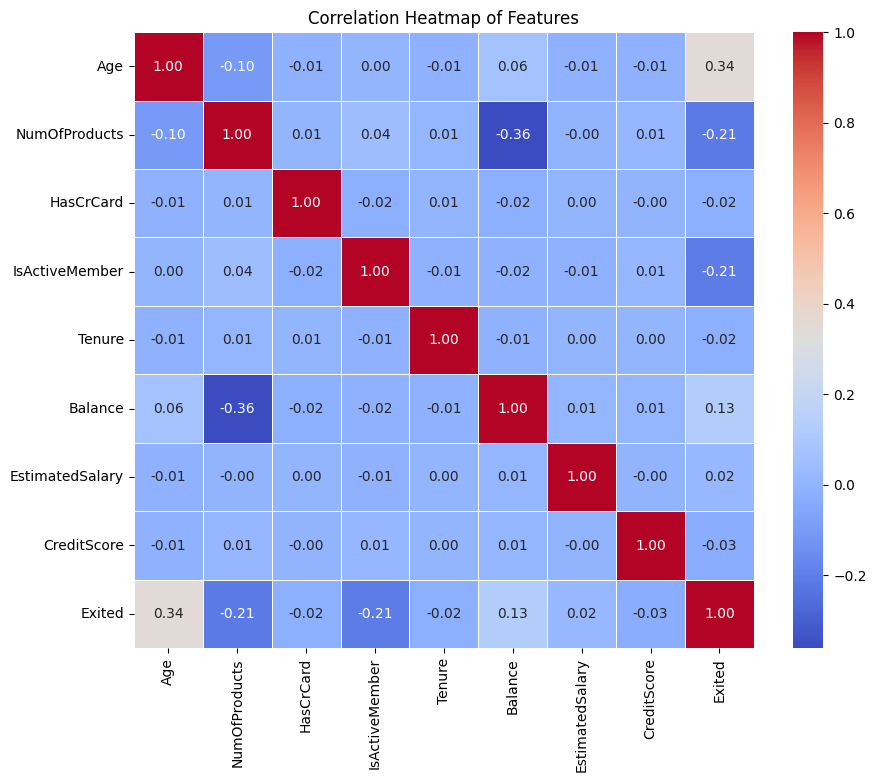

In [10]:
features_heat_num = ['Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Tenure', 'Balance', 'EstimatedSalary', 'CreditScore', 'Exited']

corr_features = train_df[features_heat_num].corr()


plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_features, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

# １．顧客情報

In [11]:

def plot_histograms(train_df, col, bins=100):
    target = 'Exited'

    bins = np.linspace(train_df[col].min(), train_df[col].max(), bins)

    data_all = train_df[col]
    data_exited_0 = train_df[train_df[target] == 0][col]
    data_exited_1 = train_df[train_df[target] == 1][col]
    
    plt.figure(figsize=(12, 6))
    plt.hist(data_all, bins=bins, alpha=0.5, color='green', label='All Data', density=False, edgecolor='black')
    plt.hist(data_exited_0, bins=bins, alpha=0.5, color='blue', label='Exited: 0', density=False, edgecolor='black')
    plt.hist(data_exited_1, bins=bins, alpha=0.5, color='orange', label='Exited: 1', density=False, edgecolor='black')

    plt.xlim(train_df[col].min(), train_df[col].max())
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col} by Exited')
    plt.legend()
    plt.show()

def barplots(train_df, col):
    target = 'Exited'

    unique_values = train_df[col].nunique()
    counts_exited_0 = train_df[train_df[target] == 0][col].value_counts().sort_index()
    counts_exited_1 = train_df[train_df[target] == 1][col].value_counts().sort_index()

    bar_width = 0.35
    indices = np.arange(len(counts_exited_0))

    plt.figure(figsize=(8, 6))
    plt.bar(indices, counts_exited_0, bar_width, label='Exited: 0', color='blue', edgecolor='black')
    plt.bar(indices + bar_width, counts_exited_1, bar_width, label='Exited: 1', color='orange', edgecolor='black')

    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Bar Chart of {col} by Exited')
    plt.xticks(indices + bar_width / 2, counts_exited_0.index)
    plt.legend()
    plt.show()

# def astype_to_float(train_df, test_df, col):
#     if train_df[col].dtype == 'object':
#         train_df[col] = train_df[col].astype(float)
#         test_df[col] = test_df[col].astype(float)

def label_encoding(train_df, test_df, col):
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col])
        test_df[col] = le.fit_transform(test_df[col])

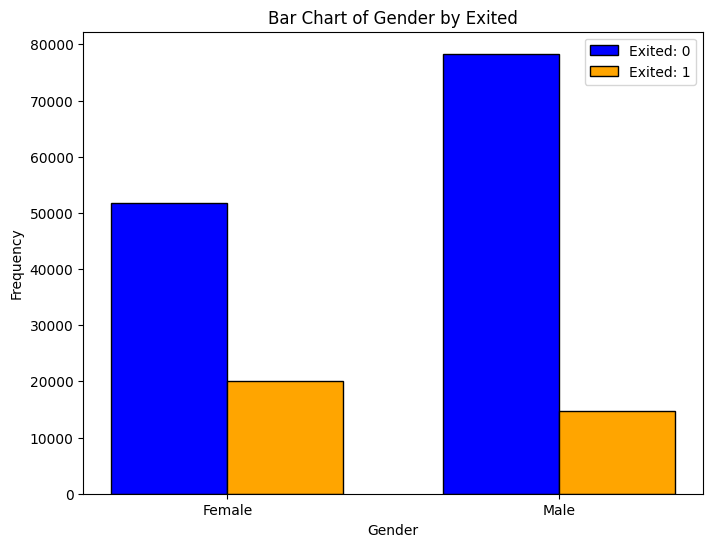

In [12]:
# 'Geography' (0:Female, 1:Male)
label_encoding(train_df, test_df, 'Gender')
barplots(train_df, 'Gender')

女性の方が解約率が高い。十分に特徴量をして扱えるはず。

In [13]:
# 'Age'
print(train_df['Age'].min())
print(train_df['Age'].max())

18.0
92.0


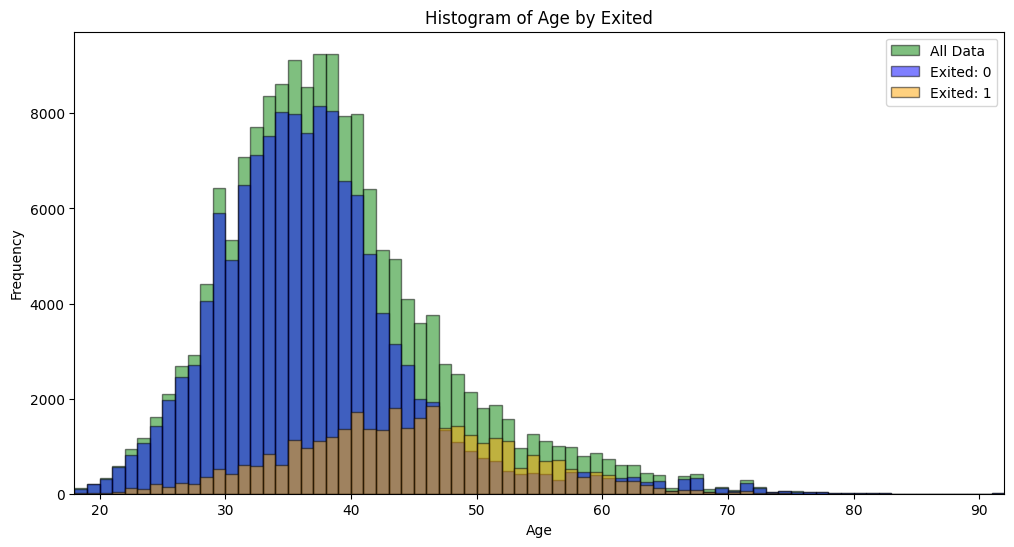

In [14]:
plot_histograms(train_df, 'Age', bins=75) # 1歳ごと

＜考察＞
* 中年世代が比較的高い解約数となっている。
* 特に、50〜60代前後は解約していない人も少ない。
* 年代ごとに傾向が異なるので、ビンニングもありか。
* 最大値94はありえない数字ではないので、外れ値の設定はなし。

In [15]:
# ビンの範囲を設定

bins = [10, 20, 30, 40, 50, 60, 70, 80, 100]
labels = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-99']

# bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
# labels = ['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94']

train_df['Age'] = train_df['Age'].astype(int)
test_df['Age'] = test_df['Age'].astype(int)

# pd.cut()を使って年齢をビンに分ける
train_df['Age_group'] = pd.cut(train_df['Age'], bins=bins, labels=labels, right=False)
test_df['Age_group'] = pd.cut(test_df['Age'], bins=bins, labels=labels, right=False)

In [16]:
crosstab_age_group = pd.crosstab(train_df['Age_group'], train_df['Exited'])
crosstab_age_group['Exited_1_ratio'] = crosstab_age_group[1] / (crosstab_age_group[0] + crosstab_age_group[1])
crosstab_age_group

Exited,0,1,Exited_1_ratio
Age_group,,,
10-19,298,34,0.102410
20-29,21270,1932,0.083269
30-39,72454,8799,0.108291
40-49,28244,15075,0.348000
50-59,4760,7426,0.609388
60-69,2400,1520,0.387755
70-79,635,128,0.167759
80-99,52,7,0.118644


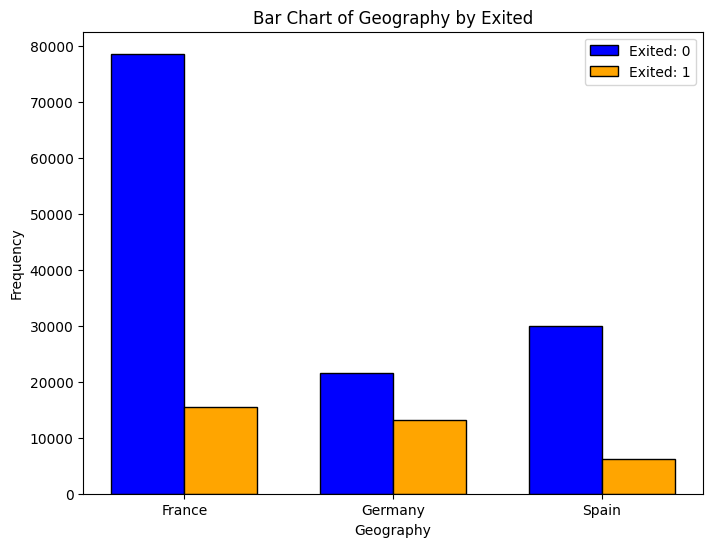

In [17]:
# Geography
label_encoding(train_df, test_df, 'Geography')
barplots(train_df, 'Geography')

In [18]:
crosstab_Geography = pd.crosstab(train_df['Geography'], train_df['Exited'])
crosstab_Geography['Exited_1_ratio'] = crosstab_Geography[1] / (crosstab_Geography[0] + crosstab_Geography[1])
crosstab_Geography

Exited,0,1,Exited_1_ratio
Geography,,,
France,78643,15572,0.165282
Germany,21492,13114,0.378952
Spain,29978,6235,0.172176


＜考察＞

* ドイツの解約率が高いことで差別化できている。
* フランスとスペインはほぼ同等だが、デン帯におけるフランスの割合が高いなど、差異はあるので特徴量に追加する。

# ２．銀行の情報

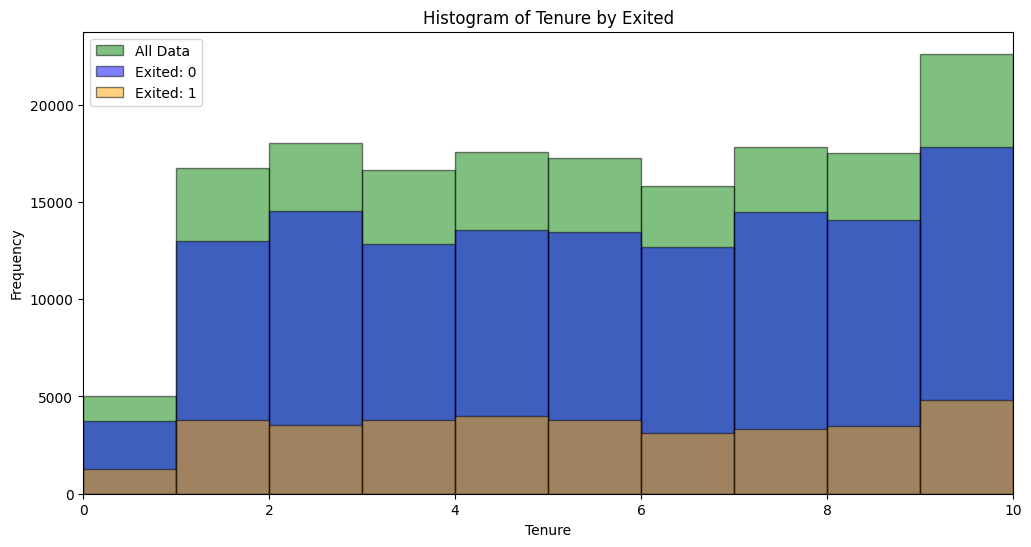

In [19]:
# Tenure
plot_histograms(train_df, 'Tenure', bins=11)

In [20]:
# それぞれの割合を計算
crosstab_Tenure = pd.crosstab(train_df['Tenure'], train_df['Exited'])
crosstab_Tenure['Exited_1_ratio'] = crosstab_Tenure[1] / (crosstab_Tenure[0] + crosstab_Tenure[1])
crosstab_Tenure

Exited,0,1,Exited_1_ratio
Tenure,,,
0,3731,1276,0.254843
1,12970,3790,0.226134
2,14529,3516,0.194846
3,12820,3810,0.229104
4,13580,3974,0.226387
5,13468,3800,0.220060
6,12677,3145,0.198774
7,14469,3341,0.187591
8,14052,3468,0.197945


＜考察＞
* 思っていたより解約率に影響しないパラメータだった。加工してからデータに投入したい。
* 他のカラムと相関があるかもしれない。特に'Age'カラムとの相関がないか検討したい。

＜仮説メモ＞
* データのままで6〜8年の人は解約率が低い。➡️カラムをそのまま入れてみる。
* 6〜8年の人は20代前半で開設して20代後半から30代前半（解約率の低い）である影響が出ているのかも。➡️口座開設の年齢を算出する

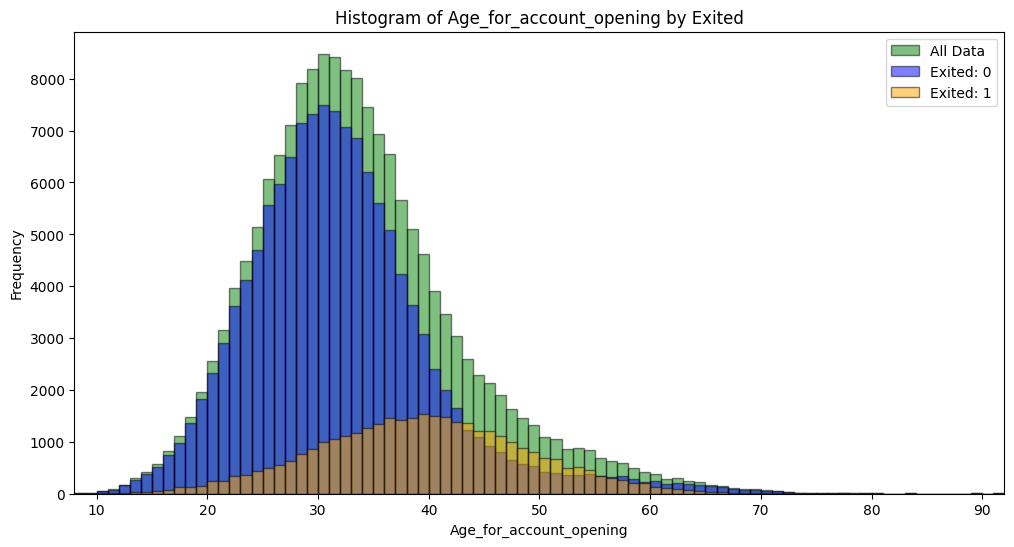

In [21]:
train_df['Age_for_account_opening'] = train_df['Age'] - train_df['Tenure']
test_df['Age_for_account_opening'] = test_df['Age'] - test_df['Tenure']

plot_histograms(train_df, 'Age_for_account_opening', bins=85) # 1歳ごと

＜考察＞
* 18歳以下でも口座開設できている理由が不明だが、特徴量としては精度向上にはならなかった。

In [22]:
# ビンの範囲を設定
bins = [10, 20, 30, 40, 50, 60, 70, 80, 100]
labels = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-99']


train_df['Age_for_account_opening'] = train_df['Age_for_account_opening'].astype(int)
test_df['Age_for_account_opening'] = test_df['Age_for_account_opening'].astype(int)

# pd.cut()を使って年齢をビンに分ける
train_df['Age_for_account_opening_group'] = pd.cut(train_df['Age_for_account_opening'], bins=bins, labels=labels, right=False)
test_df['Age_for_account_opening_group'] = pd.cut(test_df['Age_for_account_opening'], bins=bins, labels=labels, right=False)

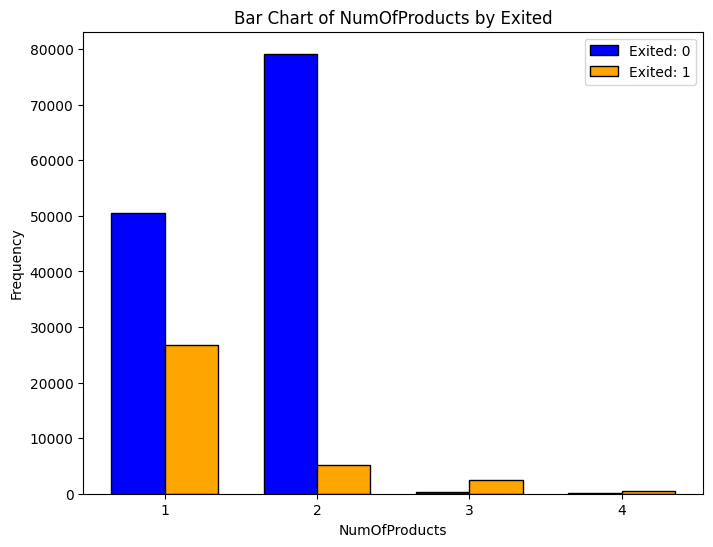

In [23]:
# NumOfProducts
barplots(train_df, 'NumOfProducts')

In [24]:
# それぞれの割合を計算
crosstab_NumOfProducts = pd.crosstab(train_df['NumOfProducts'], train_df['Exited'])
crosstab_NumOfProducts['Exited_1_ratio'] = crosstab_NumOfProducts[1] / (crosstab_NumOfProducts[0] + crosstab_NumOfProducts[1])
crosstab_NumOfProducts

Exited,0,1,Exited_1_ratio
NumOfProducts,,,
1,50516,26858,0.347119
2,79198,5093,0.060422
3,340,2554,0.882516
4,59,416,0.875789


＜考察＞
* 2個持ちが解約率がかなり低い。
* 1個だけや3個以上になると解約率が多くなる。

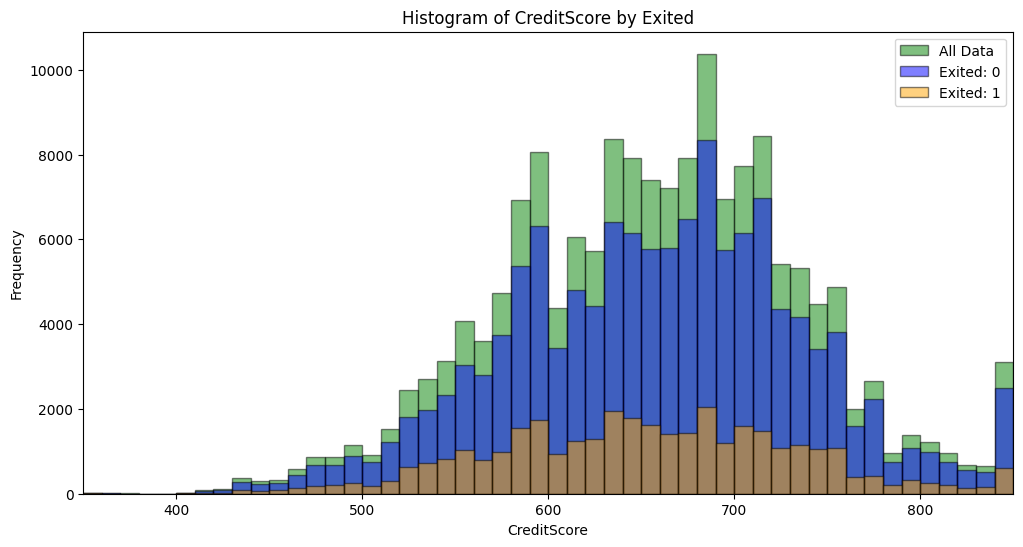

In [25]:
plot_histograms(train_df, 'CreditScore', bins=51)

＜考察＞
* 信用スコアで見たとき、まばらだが若干の特徴あり。特徴量として入れてみる。

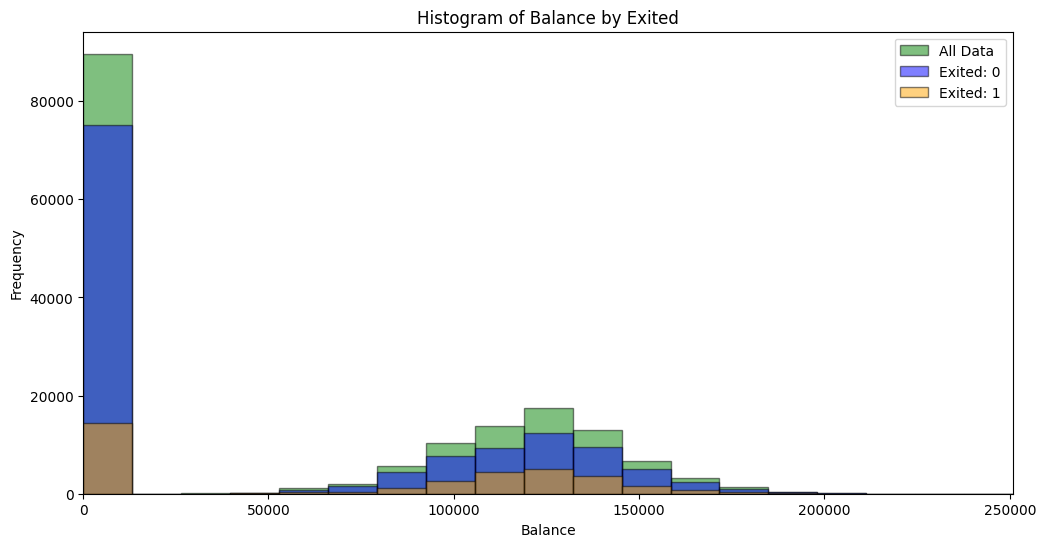

In [26]:
plot_histograms(train_df, 'Balance', bins=20)

In [27]:
train_df['Balance'].min()

0.0

＜考察＞
* 口座の残額が0である人が大多数。➡️残高０をターゲットエンコーディングする。
* それ以外の範囲は、解約の傾向は薄い。➡
* 口座あたりの残高のカラムも作ってみる

In [28]:
train_df['Balance_is_zero'] = np.where(train_df['Balance'] == 0, 1, 0)
train_df['Balance_is_zero'].sum()

89648

＜考察＞
* 残高ゼロのフラグを付けても、重要度がかなり低く精度改善にならなかった。元のカラムで説明がついていそう。

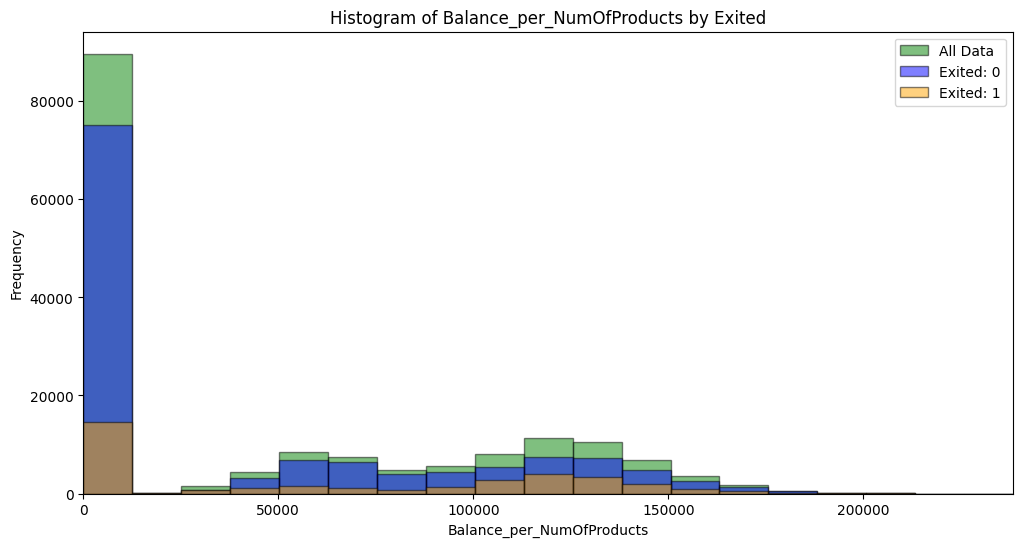

In [29]:
train_df['Balance_per_NumOfProducts'] = train_df['Balance'] / train_df['NumOfProducts']
test_df['Balance_per_NumOfProducts'] = test_df['Balance'] / test_df['NumOfProducts']
plot_histograms(train_df, 'Balance_per_NumOfProducts', bins=20)

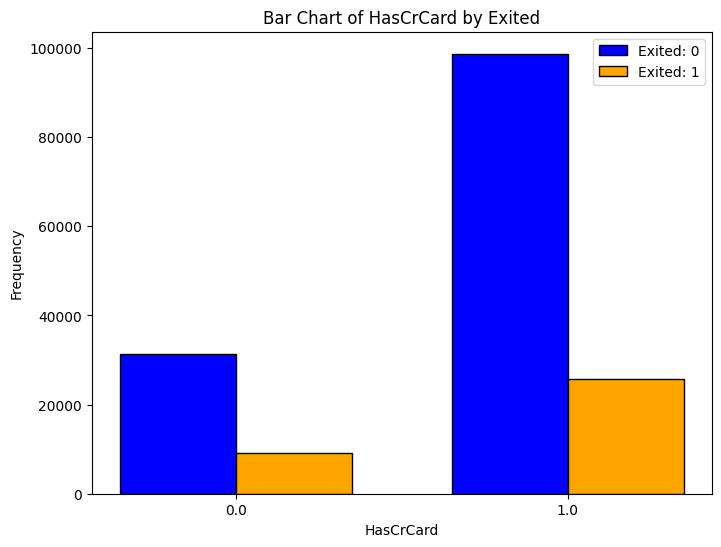

In [30]:
# HasCrCard
barplots(train_df, 'HasCrCard')

In [31]:
train_df['HasCrCard'] = train_df['HasCrCard'].astype(int)
test_df['HasCrCard'] = test_df['HasCrCard'].astype(int)

crosstab_HasCrCard = pd.crosstab(train_df['HasCrCard'], train_df['Exited'])
crosstab_HasCrCard['Exited_1_ratio'] = crosstab_HasCrCard[1] / (crosstab_HasCrCard[0] + crosstab_HasCrCard[1])
crosstab_HasCrCard

Exited,0,1,Exited_1_ratio
HasCrCard,,,
0,31371,9235,0.227429
1,98742,25686,0.206433


＜考察＞
* 若干の違いあり。特徴量に入れつつ確認する。

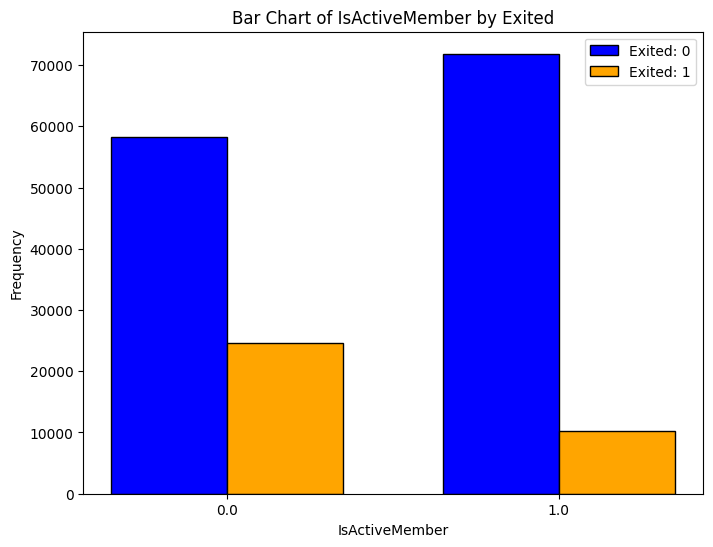

In [32]:
# IsActiveMember
barplots(train_df, 'IsActiveMember')

In [33]:
train_df['IsActiveMember'] = train_df['IsActiveMember'].astype(int)
test_df['IsActiveMember'] = test_df['IsActiveMember'].astype(int)

crosstab_IsActiveMember = pd.crosstab(train_df['IsActiveMember'], train_df['Exited'])
crosstab_IsActiveMember['Exited_1_ratio'] = crosstab_IsActiveMember[1] / (crosstab_IsActiveMember[0] + crosstab_IsActiveMember[1])
crosstab_IsActiveMember

Exited,0,1,Exited_1_ratio
IsActiveMember,,,
0,58261,24624,0.297086
1,71852,10297,0.125345


＜考察＞
* 会員状態がアクティブになっていない人ほど解約率が高い。
* 会員で残高が０の場合はどうなるのか。

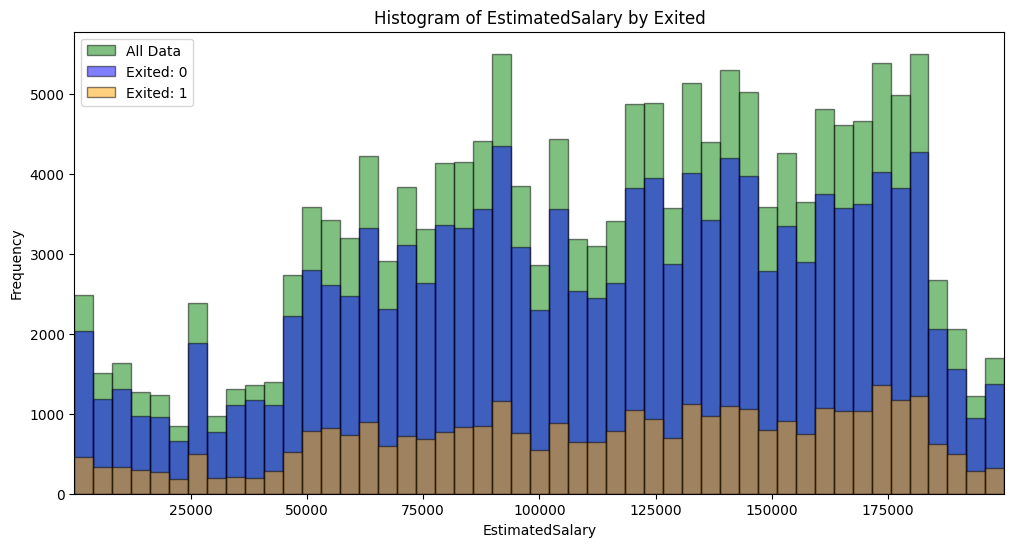

In [34]:
# EstimatedSalary
plot_histograms(train_df, 'EstimatedSalary', bins=50)

＜考察＞
* 特徴的にはまばらになっている。
* サラリーに占める貯金額でメイン口座かどうかを把握できそう。サブだと解約率が高そう。

In [35]:
train_df['Balance_per_salaly'] = train_df['Balance'] / train_df['EstimatedSalary']

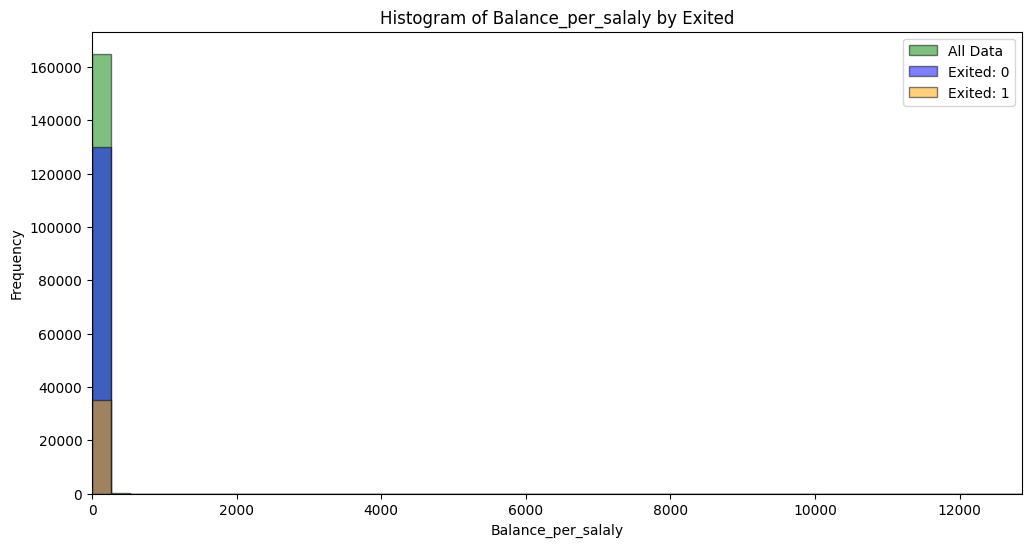

In [36]:
plot_histograms(train_df, 'Balance_per_salaly', bins=50)

In [37]:
train_df['Balance_per_salaly'].max()

12863.797

# モデル用データセット

In [38]:
features = ['Gender', 'Age', 'NumOfProducts', 'Geography', 'HasCrCard', 'IsActiveMember', 'Tenure', 'EstimatedSalary', 'CreditScore', 'Age_group', 'Age_for_account_opening_group', 'Balance_per_NumOfProducts']
x_train = train_df[features]
y_train = train_df['Exited']

In [39]:
x_tr, x_va, y_tr, y_va = train_test_split(
    x_train,
    y_train,
    shuffle=True,
    test_size=0.2,
    stratify=y_train,
    random_state=123
)

print(x_tr.shape)  # 特徴量の形状を確認
print(y_tr.shape)  # ターゲットの形状を確認

(132027, 12)
(132027,)


# モデル試作

In [40]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'random_state': 123,
    'num_leaves': 16,
    'n_estimators': 1000,
    'importance_type': 'gain',
    'verbose': 1,
    'min_data_in_leaf': 100,
    'max_depth': 5,
    'lambda_l1': 0.1,    
    'lambda_l2': 0.5,
    'feature_fraction': 0.6, 
    'bagging_fraction': 0.6, 
    'bagging_freq': 4,
}

In [41]:
model = lgb.LGBMClassifier(**params)
model.fit(
    x_tr, y_tr,
    eval_set= [(x_tr, y_tr), (x_va, y_va)],
    callbacks=[
        lgb.callback.early_stopping(stopping_rounds=100),
        lgb.callback.log_evaluation(period=100)
    ]
)

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. 

LGBMClassifier(bagging_fraction=0.6, bagging_freq=4, feature_fraction=0.6,
               importance_type='gain', lambda_l1=0.1, lambda_l2=0.5,
               learning_rate=0.05, max_depth=5, metric='auc',
               min_data_in_leaf=100, n_estimators=1000, num_leaves=16,
               objective='binary', random_state=123, verbose=1)

In [42]:
y_tr_pred = model.predict_proba(x_tr)[:, 1]
y_va_pred = model.predict_proba(x_va)[:, 1]

metric_tr = roc_auc_score(y_tr, y_tr_pred)
metric_va = roc_auc_score(y_va, y_va_pred)

print("Tr:", metric_tr)
print("Va:", metric_va)

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. 

# クロスバリデーション

In [43]:
metric=[]
imp=pd.DataFrame()
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

for nfold, (train_index, val_index) in enumerate(cv.split(x_train, y_train)):
    print('-'*20, nfold, '-'*20)
    x_tr, y_tr = x_train.iloc[train_index], y_train.iloc[train_index]
    x_va, y_va = x_train.iloc[val_index], y_train.iloc[val_index]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        x_tr, y_tr,
        eval_set= [(x_tr, y_tr), (x_va, y_va)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100)
        ]
    )
    
    y_tr_pred = model.predict_proba(x_tr)[:, 1]
    y_va_pred = model.predict_proba(x_va)[:, 1]
    
    metric_tr = roc_auc_score(y_tr, y_tr_pred)
    metric_va = roc_auc_score(y_va, y_va_pred)

    metric.append((nfold, metric_tr, metric_va))
    
    print("Tr:", metric_tr)
    print("Va:", metric_va)
    
    _imp = pd.DataFrame({
        'col': x_train.columns,
        'imp': model.feature_importances_,
        'fold': nfold
    })
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

print('-'*50)
print(pd.DataFrame(metric, columns=["Fold", "Train", "Va"]))
print('-'*50)

metric = np.array(metric)
print('[tr]: {:3f}+-{:2f}'.format(metric[:, 1].mean(), metric[:, 1].std()), '[va]: {:3f}+-{:2f}'.format(metric[:, 2].mean(), metric[:, 2].std()))

-------------------- 0 --------------------
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set

In [44]:
imp_df = imp.groupby('col')['imp'].agg(['mean', 'std'])
imp_df.columns = ['imp', 'imp_std']
imp_df.reset_index(drop=False)
imp_df.sort_values('imp', ascending=False)

,imp,imp_std
col,,
NumOfProducts,116523.496782,923.163288
Age,88661.415230,433.015903
IsActiveMember,33687.729221,205.964545
Balance_per_NumOfProducts,24563.668620,943.561206
Geography,19992.891499,405.913507
Age_for_account_opening_group,19948.296976,254.469909
Age_group,16537.009135,105.378694
Gender,10202.989100,250.086333
CreditScore,7017.137276,1298.353595


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. 

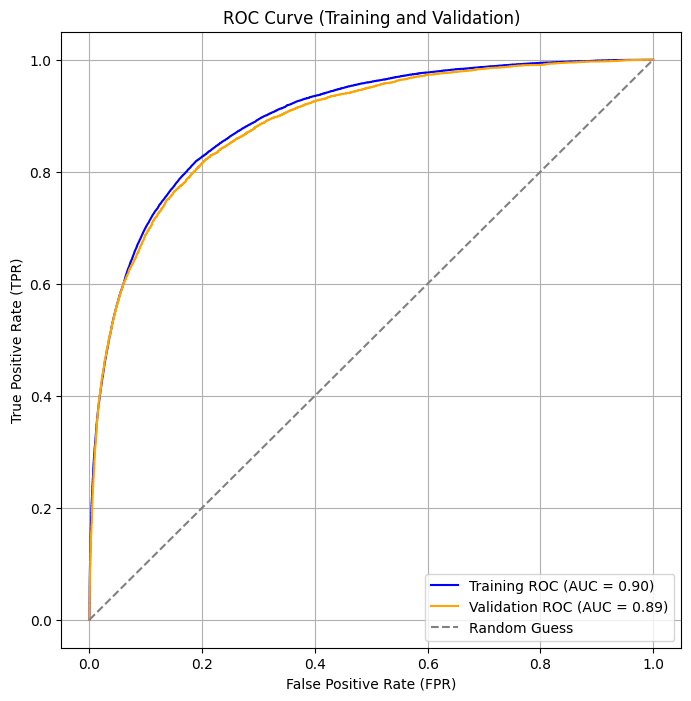

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score

y_tr_score = model.predict_proba(x_tr)[:, 1]
y_va_score = model.predict_proba(x_va)[:, 1]

fpr_tr, tpr_tr, _ = roc_curve(y_tr, y_tr_score)
auc_tr = roc_auc_score(y_tr, y_tr_score)

fpr_va, tpr_va, _ = roc_curve(y_va, y_va_score)
auc_va = roc_auc_score(y_va, y_va_score)

plt.figure(figsize=(8, 8))
plt.plot(fpr_tr, tpr_tr, label=f'Training ROC (AUC = {auc_tr:.2f})', color='blue')
plt.plot(fpr_va, tpr_va, label=f'Validation ROC (AUC = {auc_va:.2f})', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (Training and Validation)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Optuna

In [46]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [47]:
import optuna
import gc
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Objective function for Optuna optimization
def objective(trial, x_train, y_train):
    lgbm_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-2, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-2, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 32),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbose': -1,
    }

    metric = []
    imp = pd.DataFrame()
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

    for nfold, (train_index, val_index) in enumerate(cv.split(x_train, y_train)):
        print('-'*20, nfold, '-'*20)
        x_tr, y_tr = x_train.iloc[train_index], y_train.iloc[train_index]
        x_va, y_va = x_train.iloc[val_index], y_train.iloc[val_index]

        model = lgb.LGBMClassifier(**lgbm_params)
        model.fit(
            x_tr, y_tr,
            eval_set=[(x_tr, y_tr), (x_va, y_va)],
            callbacks=[
                lgb.callback.early_stopping(stopping_rounds=100),
                lgb.callback.log_evaluation(period=100)
            ]
        )
        
        y_tr_pred = model.predict_proba(x_tr)[:, 1]
        y_va_pred = model.predict_proba(x_va)[:, 1]
        
        metric_tr = roc_auc_score(y_tr, y_tr_pred)
        metric_va = roc_auc_score(y_va, y_va_pred)

        metric.append((nfold, metric_tr, metric_va))
        
        print("Tr:", metric_tr)
        print("Va:", metric_va)
        
        _imp = pd.DataFrame({
            'col': x_train.columns,
            'imp': model.feature_importances_,
            'fold': nfold
        })
        imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

    print('-'*50)
    print(pd.DataFrame(metric, columns=["Fold", "Train", "Va"]))
    print('-'*50)

    metric = np.array(metric)
    print('[tr]: {:3f}+-{:2f}'.format(metric[:, 1].mean(), metric[:, 1].std()), '[va]: {:3f}+-{:2f}'.format(metric[:, 2].mean(), metric[:, 2].std()))

    return np.mean(metric[:, 2])  # Return the validation AUC as the optimization target

# Optunaでのハイパーパラメータ最適化
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, x_train, y_train), n_trials=10)

# 最良のパラメータをリストに格納
params_list = [trial.params for trial in study.trials]

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Value: ", study.best_value)

# 選択した範囲のRMSLEスコアを格納するリスト（必要に応じて）
valid_params_with_rmsle = []

# ここで特徴量の重要度を保存して後で分析する
imp = imp.groupby('col').agg({'imp': 'mean'}).reset_index()
print("Feature Importances:")
print(imp.sort_values(by='imp', ascending=False))


[I 2024-12-16 13:05:55,945] A new study created in memory with name: no-name-78cabadd-34f7-4ded-9c5a-ccbabaa8211e


-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.87602	valid_1's auc: 0.873204
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.87606	valid_1's auc: 0.873276
Tr: 0.8760603592481887
Va: 0.8732756849731882
-------------------- 1 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.875188	valid_1's auc: 0.877664
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.875267	valid_1's auc: 0.877743
Tr: 0.8752666328383971
Va: 0.8777428182858242
-------------------- 2 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.875029	valid_1's auc: 0.87711
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.875029	valid_1's auc: 0.87711
Tr: 0.8750293242278693
Va: 0.8771103539388168
-------------------- 3 --------------------
Training until validation scores

[I 2024-12-16 13:06:08,882] Trial 0 finished with value: 0.8754282709026177 and parameters: {'lambda_l1': 0.022323746824962326, 'lambda_l2': 0.14322183419494536, 'num_leaves': 2, 'feature_fraction': 0.4137544232921691, 'bagging_fraction': 0.9664624798601138, 'bagging_freq': 1, 'min_child_samples': 15}. Best is trial 0 with value: 0.8754282709026177.


Tr: 0.8754240562250135
Va: 0.8751013714010429
--------------------------------------------------
   Fold     Train        Va
0     0  0.876060  0.873276
1     1  0.875267  0.877743
2     2  0.875029  0.877110
3     3  0.875886  0.873911
4     4  0.875424  0.875101
--------------------------------------------------
[tr]: 0.875533+-0.000384 [va]: 0.875428+-0.001745
-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.893954	valid_1's auc: 0.887718
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.893885	valid_1's auc: 0.887729
Tr: 0.8938850645290168
Va: 0.8877291600007202
-------------------- 1 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.893063	valid_1's auc: 0.890946
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.893063	valid_1's auc: 0.890946
Tr: 0.893063181633443
Va: 0.8909458629842779
----------------

[I 2024-12-16 13:06:32,330] Trial 1 finished with value: 0.8895648336715214 and parameters: {'lambda_l1': 0.015348175305668442, 'lambda_l2': 0.4063579090207974, 'num_leaves': 17, 'feature_fraction': 0.7821239672641185, 'bagging_fraction': 0.703279543113702, 'bagging_freq': 1, 'min_child_samples': 47}. Best is trial 1 with value: 0.8895648336715214.


Tr: 0.8931825922786008
Va: 0.8891400586410142
--------------------------------------------------
   Fold     Train        Va
0     0  0.893885  0.887729
1     1  0.893063  0.890946
2     2  0.892775  0.891309
3     3  0.893511  0.888700
4     4  0.893183  0.889140
--------------------------------------------------
[tr]: 0.893283+-0.000382 [va]: 0.889565+-0.001360
-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.894268	valid_1's auc: 0.887625
Did not meet early stopping. Best iteration is:
[96]	training's auc: 0.894076	valid_1's auc: 0.887631
Tr: 0.8940756476374301
Va: 0.8876306839147801
-------------------- 1 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.893504	valid_1's auc: 0.890772
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.893504	valid_1's auc: 0.890772
Tr: 0.8935036931857366
Va: 0.8907717340449428
---------------

[I 2024-12-16 13:06:58,129] Trial 2 finished with value: 0.8894103598096212 and parameters: {'lambda_l1': 0.16156882260617952, 'lambda_l2': 0.2946397025426784, 'num_leaves': 19, 'feature_fraction': 0.8140638497384362, 'bagging_fraction': 0.7816666165527433, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 1 with value: 0.8895648336715214.


Tr: 0.8938794666880501
Va: 0.8892715531346593
--------------------------------------------------
   Fold     Train        Va
0     0  0.894076  0.887631
1     1  0.893504  0.890772
2     2  0.893419  0.890893
3     3  0.893961  0.888485
4     4  0.893879  0.889272
--------------------------------------------------
[tr]: 0.893768+-0.000259 [va]: 0.889410+-0.001272
-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.893721	valid_1's auc: 0.887712
Did not meet early stopping. Best iteration is:
[97]	training's auc: 0.893572	valid_1's auc: 0.887764
Tr: 0.8935722429045359
Va: 0.8877635929296663
-------------------- 1 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.892992	valid_1's auc: 0.890798
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.892992	valid_1's auc: 0.890798
Tr: 0.8929920091158815
Va: 0.8907978338529416
---------------

[I 2024-12-16 13:07:21,437] Trial 3 finished with value: 0.8894800063907484 and parameters: {'lambda_l1': 0.01385801103135859, 'lambda_l2': 0.9968730034713179, 'num_leaves': 17, 'feature_fraction': 0.7245141921053736, 'bagging_fraction': 0.7282408604259257, 'bagging_freq': 1, 'min_child_samples': 51}. Best is trial 1 with value: 0.8895648336715214.


Tr: 0.8932845429293179
Va: 0.8893073932595408
--------------------------------------------------
   Fold     Train        Va
0     0  0.893572  0.887764
1     1  0.892992  0.890798
2     2  0.892745  0.891084
3     3  0.893399  0.888447
4     4  0.893285  0.889307
--------------------------------------------------
[tr]: 0.893199+-0.000295 [va]: 0.889480+-0.001292
-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.894976	valid_1's auc: 0.88807
Did not meet early stopping. Best iteration is:
[98]	training's auc: 0.894842	valid_1's auc: 0.888096
Tr: 0.8948420306737604
Va: 0.8880961006870343
-------------------- 1 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.894301	valid_1's auc: 0.890807
Did not meet early stopping. Best iteration is:
[94]	training's auc: 0.893896	valid_1's auc: 0.890833
Tr: 0.8938955283853351
Va: 0.8908328830311754
-----------------

[I 2024-12-16 13:07:45,953] Trial 4 finished with value: 0.8895818565982843 and parameters: {'lambda_l1': 1.437088615639336, 'lambda_l2': 0.057675645984925514, 'num_leaves': 22, 'feature_fraction': 0.931834329489435, 'bagging_fraction': 0.8571683389472671, 'bagging_freq': 1, 'min_child_samples': 86}. Best is trial 4 with value: 0.8895818565982843.


Tr: 0.8946157879282888
Va: 0.8893365341670978
--------------------------------------------------
   Fold     Train        Va
0     0  0.894842  0.888096
1     1  0.893896  0.890833
2     2  0.894053  0.891088
3     3  0.894370  0.888556
4     4  0.894616  0.889337
--------------------------------------------------
[tr]: 0.894355+-0.000349 [va]: 0.889582+-0.001196
-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.894966	valid_1's auc: 0.88744
Did not meet early stopping. Best iteration is:
[96]	training's auc: 0.894788	valid_1's auc: 0.887463
Tr: 0.8947878965474769
Va: 0.887462896290659
-------------------- 1 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.894074	valid_1's auc: 0.890826
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.894018	valid_1's auc: 0.890836
Tr: 0.8940179782177576
Va: 0.890835722179679
-------------------

[I 2024-12-16 13:08:11,453] Trial 5 finished with value: 0.8893900044833005 and parameters: {'lambda_l1': 0.027252183004405767, 'lambda_l2': 0.15194681128327311, 'num_leaves': 20, 'feature_fraction': 0.8227622030775896, 'bagging_fraction': 0.7856850751198656, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 4 with value: 0.8895818565982843.


Tr: 0.893889112525011
Va: 0.8892049213710523
--------------------------------------------------
   Fold     Train        Va
0     0  0.894788  0.887463
1     1  0.894018  0.890836
2     2  0.893942  0.890941
3     3  0.893881  0.888505
4     4  0.893889  0.889205
--------------------------------------------------
[tr]: 0.894104+-0.000346 [va]: 0.889390+-0.001344
-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.889091	valid_1's auc: 0.886303
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.889091	valid_1's auc: 0.886303
Tr: 0.8890906683443867
Va: 0.8863026887088472
-------------------- 1 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.888477	valid_1's auc: 0.889782
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.888477	valid_1's auc: 0.889782
Tr: 0.8884770634219322
Va: 0.8897817818355153
---------------

[I 2024-12-16 13:08:32,386] Trial 6 finished with value: 0.8880945518671466 and parameters: {'lambda_l1': 0.7657753731472318, 'lambda_l2': 0.25510148422902507, 'num_leaves': 6, 'feature_fraction': 0.5757463319083947, 'bagging_fraction': 0.9958903780319627, 'bagging_freq': 7, 'min_child_samples': 26}. Best is trial 4 with value: 0.8895818565982843.


Tr: 0.8888922479670734
Va: 0.887830533605233
--------------------------------------------------
   Fold     Train        Va
0     0  0.889091  0.886303
1     1  0.888477  0.889782
2     2  0.888400  0.889723
3     3  0.889044  0.886835
4     4  0.888892  0.887831
--------------------------------------------------
[tr]: 0.888781+-0.000288 [va]: 0.888095+-0.001440
-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.892538	valid_1's auc: 0.887747
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.892538	valid_1's auc: 0.887747
Tr: 0.8925375499963921
Va: 0.8877467561187723
-------------------- 1 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.891792	valid_1's auc: 0.890386
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.891792	valid_1's auc: 0.890386
Tr: 0.8917922157196583
Va: 0.8903863471466933
---------------

[I 2024-12-16 13:08:57,945] Trial 7 finished with value: 0.8892151269093871 and parameters: {'lambda_l1': 9.04670156751912, 'lambda_l2': 0.01236909425080382, 'num_leaves': 20, 'feature_fraction': 0.4790297035870643, 'bagging_fraction': 0.45558011383916813, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 4 with value: 0.8895818565982843.


Tr: 0.8918475195501746
Va: 0.8887552952154417
--------------------------------------------------
   Fold     Train        Va
0     0  0.892538  0.887747
1     1  0.891792  0.890386
2     2  0.891603  0.890910
3     3  0.892176  0.888277
4     4  0.891848  0.888755
--------------------------------------------------
[tr]: 0.891991+-0.000330 [va]: 0.889215+-0.001224
-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.892046	valid_1's auc: 0.887503
Did not meet early stopping. Best iteration is:
[96]	training's auc: 0.891871	valid_1's auc: 0.887552
Tr: 0.8918707200034465
Va: 0.8875520378505596
-------------------- 1 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.891265	valid_1's auc: 0.890602
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.891265	valid_1's auc: 0.890602
Tr: 0.8912653866805765
Va: 0.8906023122597645
---------------

[I 2024-12-16 13:09:21,946] Trial 8 finished with value: 0.889259419869852 and parameters: {'lambda_l1': 1.9803349860930282, 'lambda_l2': 1.0163541374903777, 'num_leaves': 12, 'feature_fraction': 0.8715650469247608, 'bagging_fraction': 0.7428109626729686, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 4 with value: 0.8895818565982843.


Tr: 0.891531022101595
Va: 0.8888933596191362
--------------------------------------------------
   Fold     Train        Va
0     0  0.891871  0.887552
1     1  0.891265  0.890602
2     2  0.891182  0.890818
3     3  0.891668  0.888431
4     4  0.891531  0.888893
--------------------------------------------------
[tr]: 0.891503+-0.000254 [va]: 0.889259+-0.001263
-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.895717	valid_1's auc: 0.887805
Did not meet early stopping. Best iteration is:
[90]	training's auc: 0.895131	valid_1's auc: 0.887891
Tr: 0.8951305655324634
Va: 0.8878906310696428
-------------------- 1 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.89512	valid_1's auc: 0.890338
Did not meet early stopping. Best iteration is:
[93]	training's auc: 0.894641	valid_1's auc: 0.890432
Tr: 0.894641094955312
Va: 0.8904324805587656
-------------------

[I 2024-12-16 13:09:48,089] Trial 9 finished with value: 0.8893103054852152 and parameters: {'lambda_l1': 0.010991841798037428, 'lambda_l2': 2.0877725064900465, 'num_leaves': 26, 'feature_fraction': 0.6609083837698586, 'bagging_fraction': 0.5766208200737022, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 4 with value: 0.8895818565982843.


Tr: 0.8952727894394977
Va: 0.889095389855601
--------------------------------------------------
   Fold     Train        Va
0     0  0.895131  0.887891
1     1  0.894641  0.890432
2     2  0.893686  0.890861
3     3  0.893985  0.888272
4     4  0.895273  0.889095
--------------------------------------------------
[tr]: 0.894543+-0.000622 [va]: 0.889310+-0.001167
Best Parameters:  {'lambda_l1': 1.437088615639336, 'lambda_l2': 0.057675645984925514, 'num_leaves': 22, 'feature_fraction': 0.931834329489435, 'bagging_fraction': 0.8571683389472671, 'bagging_freq': 1, 'min_child_samples': 86}
Best Value:  0.8895818565982843
Feature Importances:
                              col            imp
10                  NumOfProducts  116523.496782
0                             Age   88661.415230
9                  IsActiveMember   33687.729221
3       Balance_per_NumOfProducts   24563.668620
7                       Geography   19992.891499
1   Age_for_account_opening_group   19948.296976
2           

In [48]:
y_pred_prob = model.predict_proba(test_df[features])[:, 1]  


sub = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')
test_ids = sub['id'] 

submission = pd.DataFrame({
    'id': test_ids,
    'Exited': y_pred_prob
})

submission_name = "bank_submission4"

submission.to_csv(f'{submission_name}.csv', index=False)
submission.head()

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


,id,Exited
0,165034,0.025022
1,165035,0.790352
2,165036,0.022825
3,165037,0.239463
4,165038,0.340465
